# Results analyses

This notebook was designed to take the predictions generated after training the models, and performing results analyses based on several metrics.

## Basic imports

In [21]:
import pandas as pd
from sklearn import metrics
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4, suppress=True)
sns.set(style='darkgrid')

## Functions for classification models

Below are the definitions of functions to evaluate the classification models.

In [2]:
def eval_model(dfs):
    acc_list = list()
    bal_acc_list = list()
    prec_macro_list = list()
    prec_micro_list = list()
    rec_macro_list = list()
    f1_macro_list = list()
    f1_micro_list = list()
    
    for df in dfs:
        acc = metrics.accuracy_score(df['y_true'], df['y_pred'])
        balanced_acc = metrics.balanced_accuracy_score(df['y_true'], df['y_pred'])
        precision_macro = metrics.precision_score(df['y_true'], df['y_pred'], average='macro')
        recall_macro = metrics.recall_score(df['y_true'], df['y_pred'], average='macro')
        f1_macro = metrics.f1_score(df['y_true'], df['y_pred'], average='macro')
        f1_micro = metrics.f1_score(df['y_true'], df['y_pred'], average='micro')
        
        acc_list.append(acc)
        bal_acc_list.append(balanced_acc)
        prec_macro_list.append(precision_macro)
        rec_macro_list.append(recall_macro)
        f1_macro_list.append(f1_macro)
        f1_micro_list.append(f1_micro)

    print('Accuracy')
    print(f'Mean: {np.mean(acc_list):.4f}, Std: {np.std(acc_list):.4f}')
    print('Balanced accuracy')
    print(f'Mean: {np.mean(bal_acc_list):.4f}, Std: {np.std(bal_acc_list):.4f}')
    print('Precision macro')
    print(f'Mean: {np.mean(prec_macro_list):.4f}, Std: {np.std(prec_macro_list):.4f}')
    print('Recall macro')
    print(f'Mean: {np.mean(rec_macro_list):.4f}, Std: {np.std(rec_macro_list):.4f}')
    print('F1 macro')
    print(f'Mean: {np.mean(f1_macro_list):.4f}, Std: {np.std(f1_macro_list):.4f}')
    print('F1 micro')
    print(f'Mean: {np.mean(f1_micro_list):.4f}, Std: {np.std(f1_micro_list):.4f}')

In [3]:
def avg_cf(dfs, ax, lbl_names=None):
    cf_list = list()
    
    for df in dfs:
        cf = metrics.confusion_matrix(df['y_true'], df['y_pred'],normalize='true')
        cf_list.append(cf)
    cf_mean = np.mean(cf_list, axis=0)
    
    sns.heatmap(cf_mean, vmin=0, vmax=1, annot=True, fmt='0.2f', cbar=False, cmap='coolwarm', ax=ax)
    if lbl_names is not None:
        ax.set_xticklabels(lbl_names)
        ax.set_yticklabels(lbl_names)
    return ax

In [4]:
from sklearn.dummy import DummyClassifier

def compute_dummy(df, strategy='prior'):
    clf = DummyClassifier(strategy=strategy)
    clf.fit(df['y_true'], df['y_true'])
    df['y_pred'] = clf.predict(df['y_true'])
    return df

In [5]:
def eval_all(base_paths, lbl_names=None, dummy_strategy=None):
    for base_path in base_paths:
        dfs = list()
        print('\n', base_path)
        for i in range(4):
            path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
            df = pd.read_csv(path, index_col=0)
            if dummy_strategy is not None:
                df = compute_dummy(df, dummy_strategy)
            dfs.append(df)
        eval_model(dfs)
        #fig, ax = plt.subplots()
        #avg_cf(dfs, ax, lbl_names=lbl_names)
        #plt.show()

# Evaluating models that classify the absolute water level

Below, I evaluate the models aimed at, given an input image or a sequence of input images, classify it according to the water level.
So far, the classes are *low*, *medium*, *high* and *flood*.

In [6]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/rgbdiff_v0')
base_paths.append('/models/pair_gray_v0')
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')

In [7]:
lbl_names = ['low', 'medium', 'high', 'flood']
eval_all(base_paths, lbl_names=lbl_names)


 /models/single_rgb_v1
Accuracy
Mean: 0.9575, Std: 0.0269
Balanced accuracy
Mean: 0.6441, Std: 0.0624
Precision macro
Mean: 0.4644, Std: 0.1226
Recall macro
Mean: 0.6441, Std: 0.0624
F1 macro
Mean: 0.4845, Std: 0.1069
F1 micro
Mean: 0.9575, Std: 0.0269

 /models/rgbdiff_v0
Accuracy
Mean: 0.9147, Std: 0.0624
Balanced accuracy
Mean: 0.5450, Std: 0.0929
Precision macro
Mean: 0.3409, Std: 0.0579
Recall macro
Mean: 0.5450, Std: 0.0929
F1 macro
Mean: 0.3695, Std: 0.0825
F1 micro
Mean: 0.9147, Std: 0.0624

 /models/pair_gray_v0
Accuracy
Mean: 0.9686, Std: 0.0093
Balanced accuracy
Mean: 0.6788, Std: 0.1162
Precision macro
Mean: 0.4542, Std: 0.1282
Recall macro
Mean: 0.6788, Std: 0.1162
F1 macro
Mean: 0.4963, Std: 0.1306
F1 micro
Mean: 0.9686, Std: 0.0093

 /models/flow_v0
Accuracy
Mean: 0.9321, Std: 0.0316
Balanced accuracy
Mean: 0.5390, Std: 0.0389
Precision macro
Mean: 0.3146, Std: 0.0381
Recall macro
Mean: 0.5390, Std: 0.0389
F1 macro
Mean: 0.3391, Std: 0.0561
F1 micro
Mean: 0.9321, Std: 0

## Dummy classifiers

Here, I evaluate a set of dummy classifiers as baselines.

In [8]:
print('Majority class')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='prior')

print('\n\nStratified random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='stratified')

print('\n\nUniform random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='uniform')

Majority class

 /models/single_rgb_v1
Accuracy
Mean: 0.9891, Std: 0.0026
Balanced accuracy
Mean: 0.2500, Std: 0.0000
Precision macro
Mean: 0.2473, Std: 0.0007
Recall macro
Mean: 0.2500, Std: 0.0000
F1 macro
Mean: 0.2486, Std: 0.0003
F1 micro
Mean: 0.9891, Std: 0.0026


Stratified random

 /models/single_rgb_v1
Accuracy
Mean: 0.9783, Std: 0.0051
Balanced accuracy
Mean: 0.2519, Std: 0.0077
Precision macro
Mean: 0.2524, Std: 0.0086
Recall macro
Mean: 0.2519, Std: 0.0077
F1 macro
Mean: 0.2521, Std: 0.0081
F1 micro
Mean: 0.9783, Std: 0.0051


Uniform random

 /models/single_rgb_v1


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Accuracy
Mean: 0.2490, Std: 0.0017
Balanced accuracy
Mean: 0.2412, Std: 0.0417
Precision macro
Mean: 0.2501, Std: 0.0005
Recall macro
Mean: 0.2412, Std: 0.0417
F1 macro
Mean: 0.1048, Std: 0.0016
F1 micro
Mean: 0.2490, Std: 0.0017


# Evaluating models that classify the relative water level

Below, I evaluate the models aimed at, given a pair of input images or a sequence of such pairs, identify if the water level is stable, if it is increasing, or if it is decreasing.
So far, the classes are *up*, *down*, and *still*.

In [9]:
base_paths = list()
base_paths.append('/models/single_rgb_diffs_v0')
base_paths.append('/models/rgbdiff_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')
base_paths.append('/models/single_flow_diffs_v0')
base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')

In [10]:
lbl_names = ['down', 'still', 'up']
eval_all(base_paths, lbl_names=lbl_names)


 /models/single_rgb_diffs_v0
Accuracy
Mean: 0.8624, Std: 0.1020
Balanced accuracy
Mean: 0.6696, Std: 0.1433
Precision macro
Mean: 0.3526, Std: 0.0101
Recall macro
Mean: 0.6696, Std: 0.1433
F1 macro
Mean: 0.3442, Std: 0.0345
F1 micro
Mean: 0.8624, Std: 0.1020

 /models/rgbdiff_diffs_v0
Accuracy
Mean: 0.9073, Std: 0.0702
Balanced accuracy
Mean: 0.6257, Std: 0.0119
Precision macro
Mean: 0.3539, Std: 0.0113
Recall macro
Mean: 0.6257, Std: 0.0119
F1 macro
Mean: 0.3544, Std: 0.0294
F1 micro
Mean: 0.9073, Std: 0.0702

 /models/pair_gray_diffs_v0
Accuracy
Mean: 0.9819, Std: 0.0060
Balanced accuracy
Mean: 0.7442, Std: 0.1611
Precision macro
Mean: 0.4280, Std: 0.0187
Recall macro
Mean: 0.7442, Std: 0.1611
F1 macro
Mean: 0.4762, Std: 0.0301
F1 micro
Mean: 0.9819, Std: 0.0060

 /models/single_flow_diffs_v0
Accuracy
Mean: 0.9684, Std: 0.0110
Balanced accuracy
Mean: 0.8060, Std: 0.0813
Precision macro
Mean: 0.3944, Std: 0.0190
Recall macro
Mean: 0.8060, Std: 0.0813
F1 macro
Mean: 0.4361, Std: 0.033

## Dummy classifiers

In [12]:
print('Majority class')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='prior')

print('\n\nStratified random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='stratified')

print('\n\nUniform random')
eval_all([base_paths[0]], lbl_names=lbl_names, dummy_strategy='uniform')

Majority class

 /models/single_rgb_diffs_v0
Accuracy
Mean: 0.9962, Std: 0.0006
Balanced accuracy
Mean: 0.3333, Std: 0.0000
Precision macro
Mean: 0.3321, Std: 0.0002
Recall macro
Mean: 0.3333, Std: 0.0000
F1 macro
Mean: 0.3327, Std: 0.0001
F1 micro
Mean: 0.9962, Std: 0.0006


Stratified random

 /models/single_rgb_diffs_v0
Accuracy
Mean: 0.9922, Std: 0.0012
Balanced accuracy
Mean: 0.3320, Std: 0.0002
Precision macro
Mean: 0.3321, Std: 0.0002
Recall macro
Mean: 0.3320, Std: 0.0002
F1 macro
Mean: 0.3320, Std: 0.0002
F1 micro
Mean: 0.9922, Std: 0.0012


Uniform random

 /models/single_rgb_diffs_v0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

Accuracy
Mean: 0.3299, Std: 0.0056
Balanced accuracy
Mean: 0.3229, Std: 0.0197
Precision macro
Mean: 0.3330, Std: 0.0003
Recall macro
Mean: 0.3229, Std: 0.0197
F1 macro
Mean: 0.1676, Std: 0.0021
F1 micro
Mean: 0.3299, Std: 0.0056


# Deployable figures

### Ensure creation of results folder

In [13]:
os.makedirs(os.path.join('..','results'), exist_ok=True)

## Confusion matrices

In [14]:
def provide_all_subplots(base_paths, plot_titles, figsize=(10,8), lbl_names=None, dummy_strategy=None):
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=figsize)
    for j, base_path in enumerate(base_paths):
        dfs = list()
        for i in range(4):
            path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
            df = pd.read_csv(path, index_col=0)
            if dummy_strategy is not None:
                df = compute_dummy(df, dummy_strategy)
            dfs.append(df)
        axs[j//3,j%3] = avg_cf(dfs, axs[j//3,j%3], lbl_names=lbl_names)
        axs[j//3,j%3].set_title(plot_titles[j])
    #axs[1,2].set_visible(False)
    fig.tight_layout()
    return fig

### Absolute water level

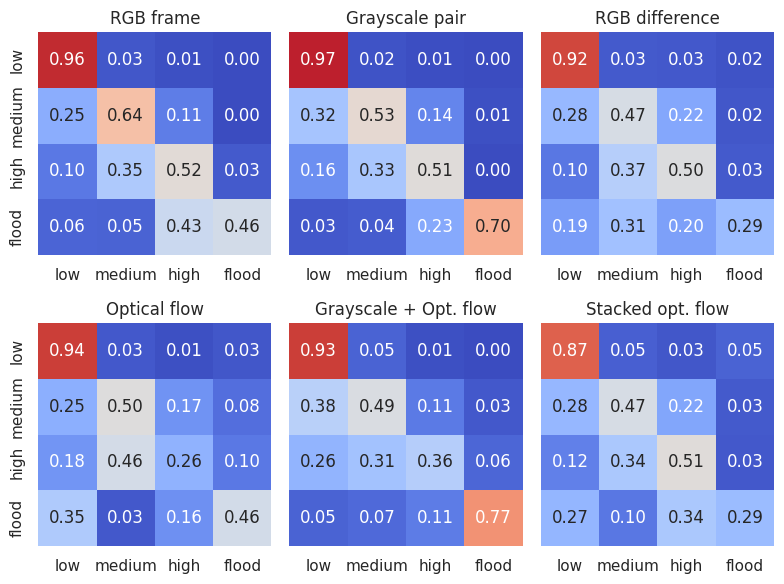

In [22]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/pair_gray_v0')
base_paths.append('/models/rgbdiff_v0')
base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
base_paths.append('/models/stack_flow_v0')

plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + Opt. flow', 'Stacked opt. flow']
lbl_names = ['low', 'medium', 'high', 'flood']

fig = provide_all_subplots(base_paths, plot_titles, figsize=(8,6), lbl_names=lbl_names)
plt.show()
fig.savefig(os.path.join('..','results','cf_level.pdf'))

### Relative water level

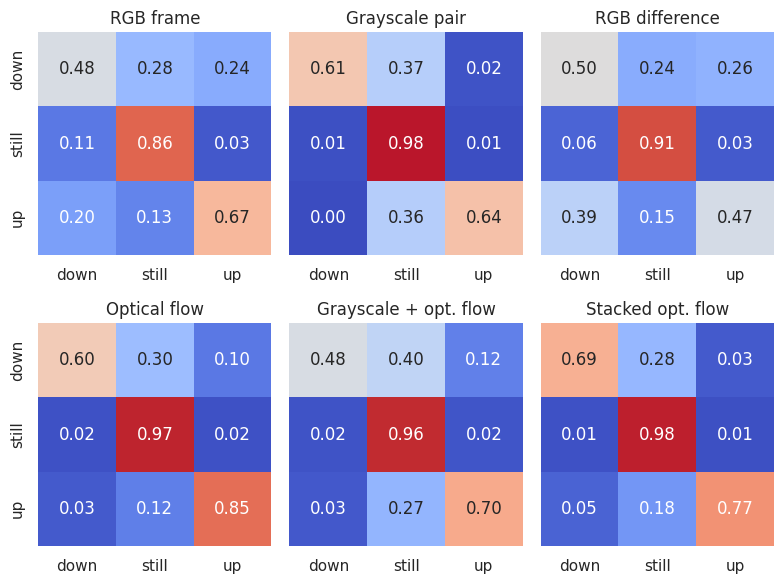

In [23]:
base_paths = list()
base_paths.append('/models/single_rgb_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')
base_paths.append('/models/rgbdiff_diffs_v0')
base_paths.append('/models/single_flow_diffs_v0')
base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')


plot_titles = ['RGB frame', 'Grayscale pair', 'RGB difference', 'Optical flow',
               'Grayscale + opt. flow', 'Stacked opt. flow']
lbl_names = ['down', 'still', 'up']

fig = provide_all_subplots(base_paths, plot_titles, figsize=(8,6), lbl_names=lbl_names)
plt.show()
fig.savefig(os.path.join('..','results','cf_diffs.pdf'))

# Significance test for confidence scores

In [24]:
from statannot import add_stat_annotation
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

In [25]:
def get_conf(base_path):
    dfs = list()
    for i in range(4):
        path = os.path.join(base_path, f'split_{i+1}', 'preds.csv')
        df = pd.read_csv(path, index_col=0)
        dfs.append(df)
    df_conf = pd.concat(dfs, ignore_index=True)
    df_conf = df_conf.rename({'y_true':'Ground truth',
                              'y_conf':'Confidence'}, axis='columns')
    df_conf = df_conf[['datetime','Ground truth','Confidence']]
    return df_conf

## Absolute water level - confidence

In [26]:
base_paths = list()
base_paths.append('/models/single_rgb_v1')
base_paths.append('/models/pair_gray_v0')
#base_paths.append('/models/rgbdiff_v0')
#base_paths.append('/models/flow_v0')
base_paths.append('/models/single_gray_flow_v0')
#base_paths.append('/models/stack_flow_v0')

plot_titles = ['RGB frame', 'Grayscale\npair', 'Grayscale +\nOpt. flow']
lbl_names = ['Low', 'Medium', 'High', 'Flood']


for i, base_path in enumerate(base_paths):
    if i==0:
        df_conf = get_conf(base_path)
    else:
        df_model = get_conf(base_path)
        df_model = df_model[['datetime','Confidence']]
        df_conf = pd.merge(df_conf, df_model, on='datetime')
    df_conf = df_conf.rename(columns={'Confidence':plot_titles[i]})
    
df_melt = pd.melt(df_conf, id_vars=['datetime','Ground truth'], var_name='Modality', value_name='Confidence')

In [27]:
df_melt.head()

,datetime,Ground truth,Modality,Confidence
0,2018-11-01 00:33:51,0,RGB frame,0.999993
1,2018-11-01 00:50:03,0,RGB frame,0.999956
2,2018-11-01 01:06:17,0,RGB frame,0.999994
3,2018-11-01 01:22:30,0,RGB frame,0.999991
4,2018-11-01 01:38:43,0,RGB frame,0.999991


In [28]:
for i, level in enumerate(lbl_names):
    if i==0:
        continue
    print(level)
    df_level = df_melt[df_melt['Ground truth']==i]
    model = AnovaRM(df_level, 'Confidence', 'datetime', within=['Modality'])
    results = model.fit()
    print(results)

Medium
                 Anova
         F Value Num DF   Den DF  Pr > F
----------------------------------------
Modality 30.8818 2.0000 1064.0000 0.0000

High
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
Modality 27.6082 2.0000 362.0000 0.0000

Flood
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
Modality 15.4929 2.0000 148.0000 0.0000



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

RGB frame v.s. Grayscale
pair: t-test paired samples with Bonferroni correction, P_val=1.206e-71 stat=-1.798e+01
Grayscale
pair v.s. Grayscale +
Opt. flow: t-test paired samples with Bonferroni correction, P_val=0.000e+00 stat=6.617e+01
RGB frame v.s. Grayscale +
Opt. flow: t-test paired samples with Bonferroni correction, P_val=0.000e+00 stat=4.983e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

RGB frame v.s. Grayscale
pair: t-test paired samples with Bonferroni correction, P_val=2.215e-03 stat=3.395e+00
Grayscale
pair v.s. Grayscale +
Opt. flow: t-test paired samples with Bonferroni correction, P_val=5.147e-05 stat=4.339e+00
RGB frame v.s. Grayscale +
Opt. flow: t-test paired samples with Bonferroni corr

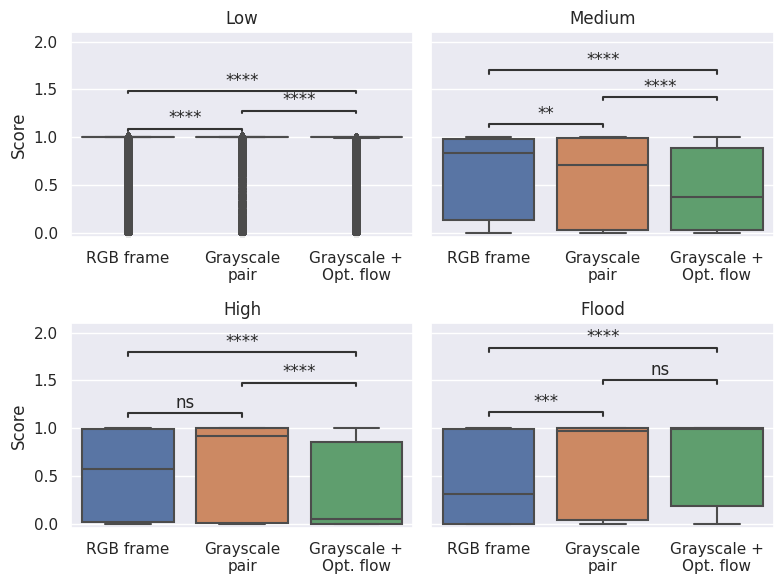

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(8,6))

for i, level in enumerate(lbl_names):
    df_level = df_melt[df_melt['Ground truth']==i]
    sns.boxplot(ax=axs[i//2,i%2], data=df_level, x='Modality', y='Confidence')
    axs[i//2,i%2].set_title(level)
    axs[i//2,i%2].set_xlabel('')
    box_pairs=[('RGB frame', 'Grayscale\npair'),
               ('Grayscale\npair', 'Grayscale +\nOpt. flow'),
               ('RGB frame','Grayscale +\nOpt. flow')]
    test_results = add_stat_annotation(axs[i//2,i%2],
                                       data=df_level, x='Modality', y='Confidence',
                                       box_pairs=box_pairs,
                                       test='t-test_paired',
                                       text_format='star',
                                       loc='inside', verbose=2)

axs[0,0].set_ylabel('Score')
axs[1,0].set_ylabel('Score')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
    
fig.tight_layout()
fig.savefig(os.path.join('..','results','confidence_abs.pdf'))
plt.show()

### Effect size

In [30]:
for i, level in enumerate(lbl_names):
    print('\n',level)
    df_level = df_melt[df_melt['Ground truth']==i]
    df_level = df_level.sort_values( by=['datetime'], ascending=[True] )
    for pair in box_pairs:
        print(pair)
        mod1, mod2 = pair
        group1 = df_level[df_level['Modality']==mod1]['Confidence']
        group2 = df_level[df_level['Modality']==mod2]['Confidence']
        d = pg.compute_effsize(group1, group2, paired=True, eftype='cohen')
        print(f'{d:.2f}')


 Low
('RGB frame', 'Grayscale\npair')
-0.07
('Grayscale\npair', 'Grayscale +\nOpt. flow')
0.31
('RGB frame', 'Grayscale +\nOpt. flow')
0.24

 Medium
('RGB frame', 'Grayscale\npair')
0.17
('Grayscale\npair', 'Grayscale +\nOpt. flow')
0.25
('RGB frame', 'Grayscale +\nOpt. flow')
0.44

 High
('RGB frame', 'Grayscale\npair')
-0.11
('Grayscale\npair', 'Grayscale +\nOpt. flow')
0.53
('RGB frame', 'Grayscale +\nOpt. flow')
0.43

 Flood
('RGB frame', 'Grayscale\npair')
-0.39
('Grayscale\npair', 'Grayscale +\nOpt. flow')
-0.11
('RGB frame', 'Grayscale +\nOpt. flow')
-0.50


## Relative water level - confidence

In [31]:
base_paths = list()
#base_paths.append('/models/single_rgb_diffs_v0')
base_paths.append('/models/pair_gray_diffs_v0')
#base_paths.append('/models/rgbdiff_diffs_v0')
base_paths.append('/models/single_flow_diffs_v0')
#base_paths.append('/models/single_gray_flow_diffs_v0')
base_paths.append('/models/stack_flow_diffs_v0')

plot_titles = ['Grayscale\npair', 'Optical\nflow', 'Stacked\nopt. flow']
lbl_names = ['Down', 'Still', 'Up']


for i, base_path in enumerate(base_paths):
    if i==0:
        df_conf = get_conf(base_path)
    else:
        df_model = get_conf(base_path)
        df_model = df_model[['datetime','Confidence']]
        df_conf = pd.merge(df_conf, df_model, on='datetime')
    df_conf = df_conf.rename(columns={'Confidence':plot_titles[i]})
    
df_melt = pd.melt(df_conf, id_vars=['datetime','Ground truth'], var_name='Modality', value_name='Confidence')

In [32]:
for i, level in enumerate(lbl_names):
    if i==1:
        continue
    print(level)
    df_level = df_melt[df_melt['Ground truth']==i]
    model = AnovaRM(df_level, 'Confidence', 'datetime', within=['Modality'])
    results = model.fit()
    print(results)

Down
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
Modality  5.9234 2.0000 256.0000 0.0031

Up
                 Anova
         F Value Num DF  Den DF  Pr > F
---------------------------------------
Modality 23.2052 2.0000 240.0000 0.0000



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Grayscale
pair v.s. Optical
flow: t-test paired samples with Bonferroni correction, P_val=1.216e-01 stat=-2.069e+00
Optical
flow v.s. Stacked
opt. flow: t-test paired samples with Bonferroni correction, P_val=6.080e-01 stat=-1.281e+00
Grayscale
pair v.s. Stacked
opt. flow: t-test paired samples with Bonferroni correction, P_val=1.699e-03 stat=-3.536e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Grayscale
pair v.s. Optical
flow: t-test paired samples with Bonferroni correction, P_val=6.174e-171 stat=2.799e+01
Optical
flow v.s. Stacked
opt. flow: t-test paired samples with Bonferroni correction, P_val=5.462e-34 stat=-1.225e+01
Grayscale
pair v.s. Stacked
opt. flow: t-test paired samples with Bonferroni corr

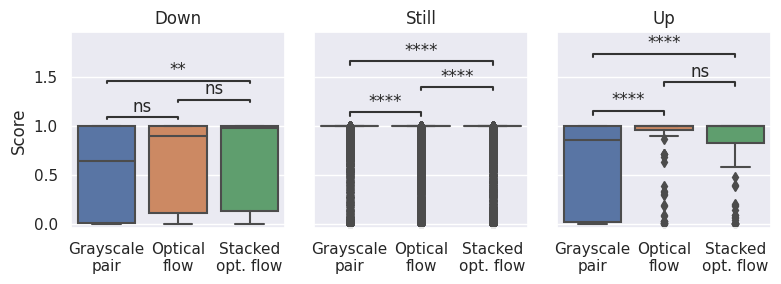

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8,3))

for i, level in enumerate(lbl_names):
    df_level = df_melt[df_melt['Ground truth']==i]
    sns.boxplot(ax=axs[i], data=df_level, x='Modality', y='Confidence')
    axs[i].set_title(level)
    axs[i].set_xlabel('')
    box_pairs=[('Grayscale\npair', 'Optical\nflow'),
               ('Optical\nflow', 'Stacked\nopt. flow'),
               ('Grayscale\npair','Stacked\nopt. flow')]
    test_results = add_stat_annotation(axs[i],
                                       data=df_level, x='Modality', y='Confidence',
                                       box_pairs=box_pairs,
                                       test='t-test_paired',
                                       text_format='star',
                                       loc='inside', verbose=2)

axs[0].set_ylabel('Score')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
    
fig.tight_layout()
fig.savefig(os.path.join('..','results','confidence_rel.pdf'))
plt.show()

### Effect size

In [34]:
for i, level in enumerate(lbl_names):
    print('\n',level)
    df_level = df_melt[df_melt['Ground truth']==i]
    df_level = df_level.sort_values( by=['datetime'], ascending=[True] )
    for pair in box_pairs:
        print(pair)
        mod1, mod2 = pair
        group1 = df_level[df_level['Modality']==mod1]['Confidence']
        group2 = df_level[df_level['Modality']==mod2]['Confidence']
        d = pg.compute_effsize(group1, group2, paired=True, eftype='cohen')
        print(f'{d:.2f}')


 Down
('Grayscale\npair', 'Optical\nflow')
-0.22
('Optical\nflow', 'Stacked\nopt. flow')
-0.14
('Grayscale\npair', 'Stacked\nopt. flow')
-0.35

 Still
('Grayscale\npair', 'Optical\nflow')
0.12
('Optical\nflow', 'Stacked\nopt. flow')
-0.05
('Grayscale\npair', 'Stacked\nopt. flow')
0.07

 Up
('Grayscale\npair', 'Optical\nflow')
-0.69
('Optical\nflow', 'Stacked\nopt. flow')
0.10
('Grayscale\npair', 'Stacked\nopt. flow')
-0.59
